Top cổ phiếu theo Wyckoff + EMA/MACD scoring:
   ticker  Volatility  VolumeAccum  VolumeBreakout  MAtrend1  MAtrend2  \
97    VPI           2            0               2         1         2   
90    TLG           2            2               2         1         0   
1     BID           2            0               0         1         2   
8     HPG           0            0               2         1         2   
60    TCH           0            0               2         1         2   
61    HSG           0            0               2         1         2   
70    NKG           0            0               2         1         2   
78    PNJ           2            0               2         1         2   
22    VCB           2            0               0         1         2   
63    IMP           2            0               0         1         2   
26    VNM           2            0               0         1         2   
68    MSB           0            0               0         1      

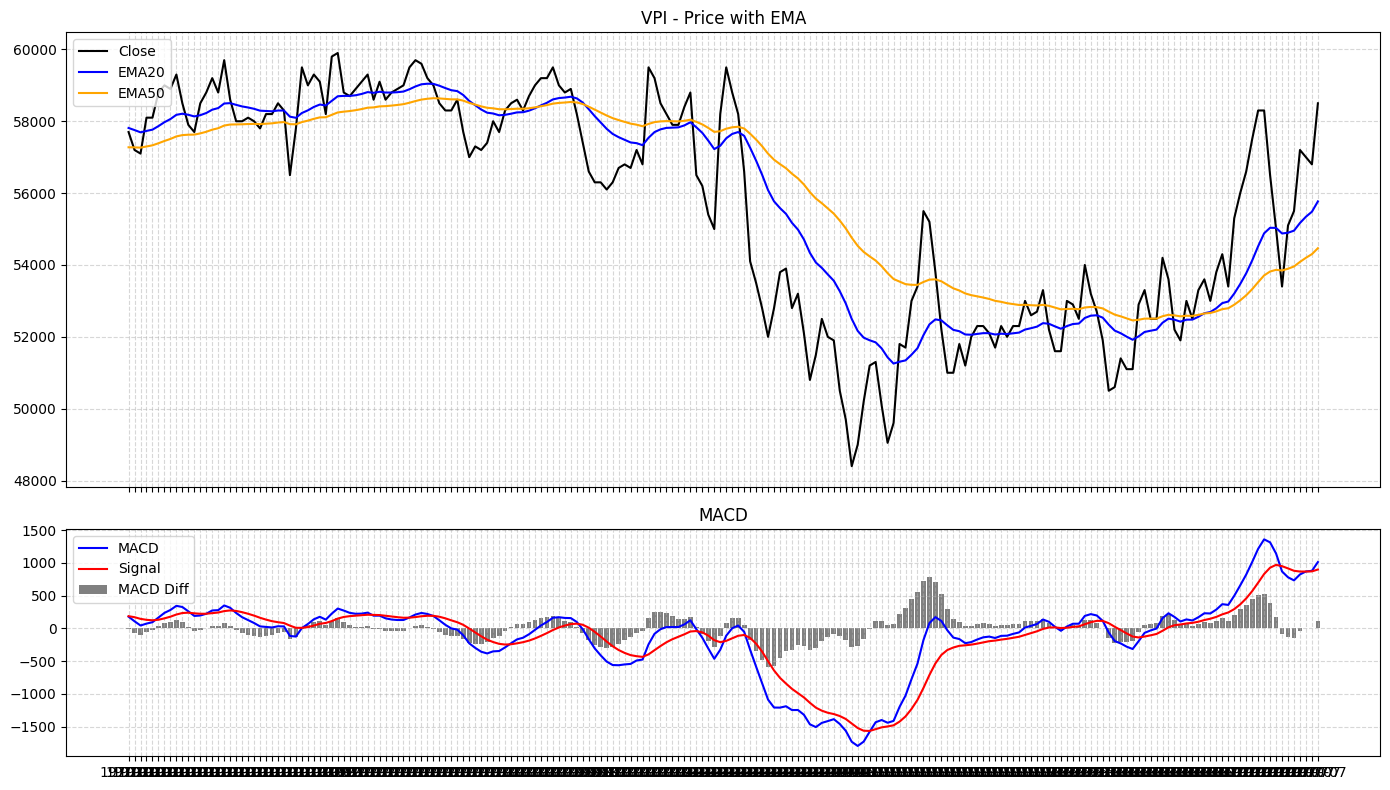

📈 Vẽ chart cho TLG


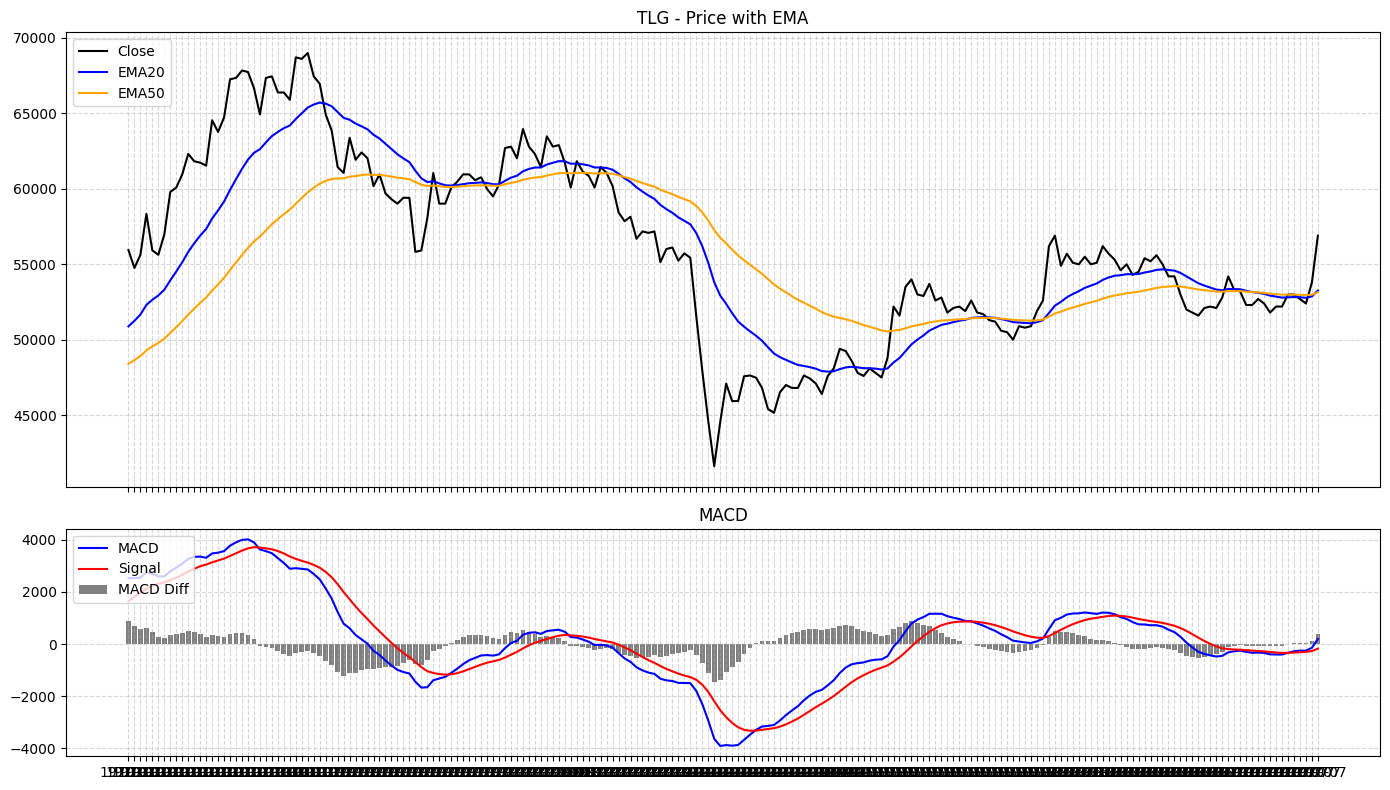

📈 Vẽ chart cho BID


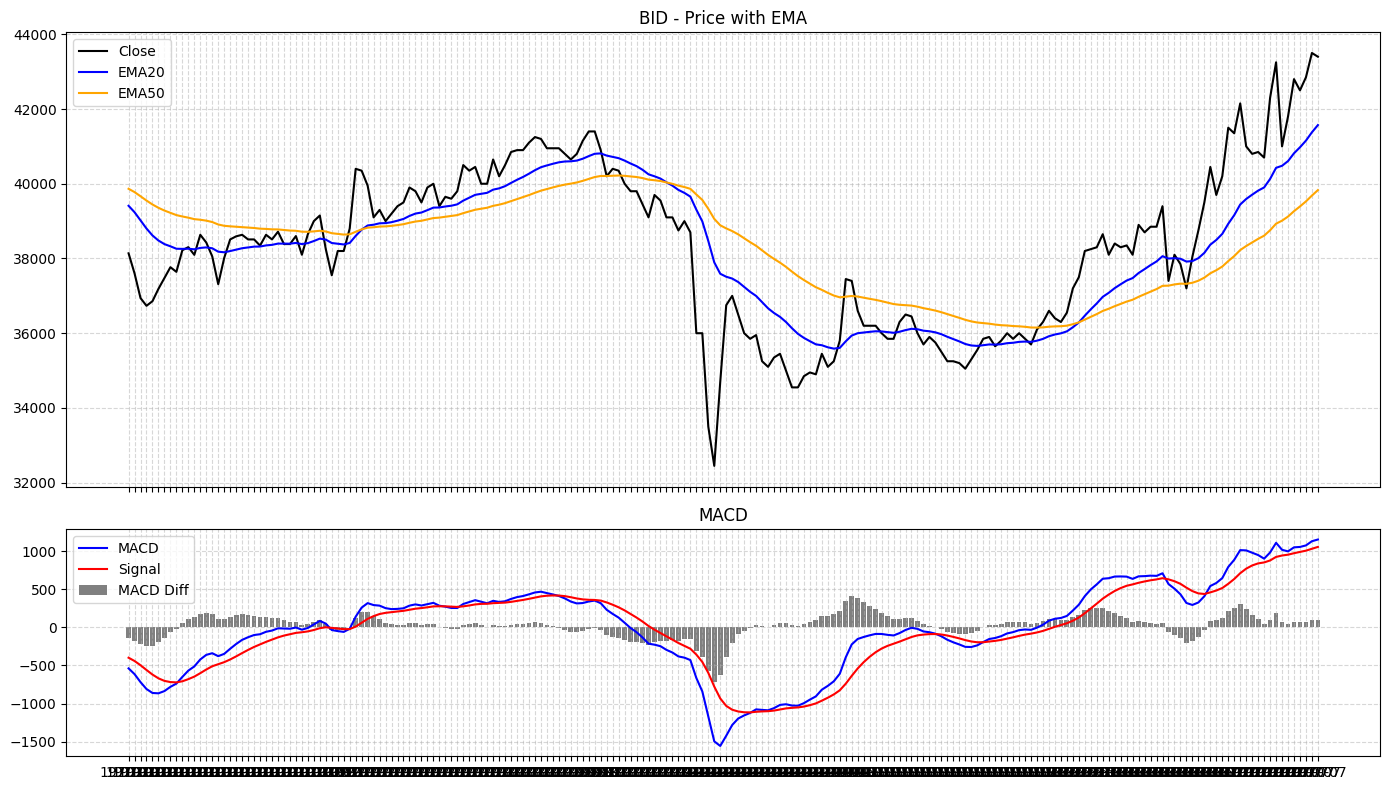

📈 Vẽ chart cho HPG


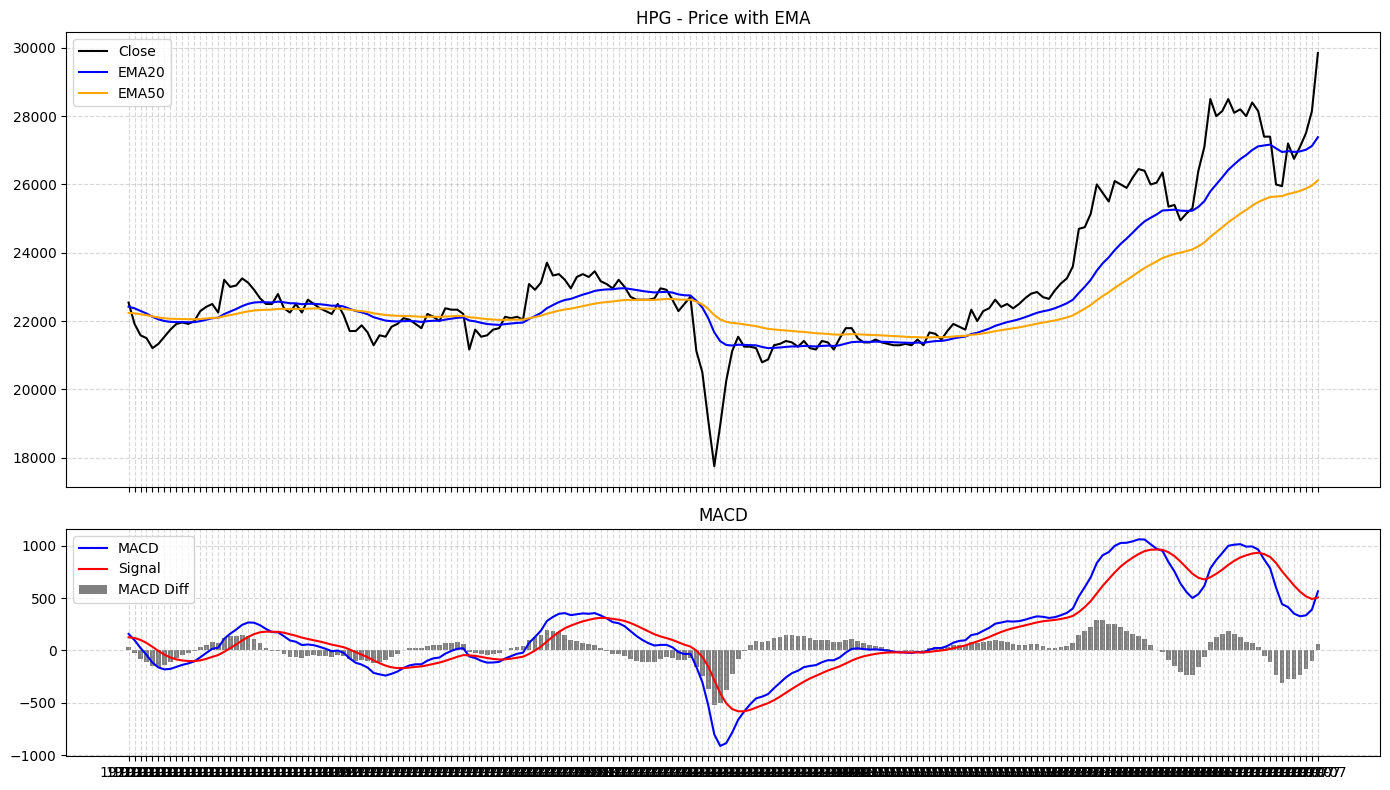

📈 Vẽ chart cho TCH


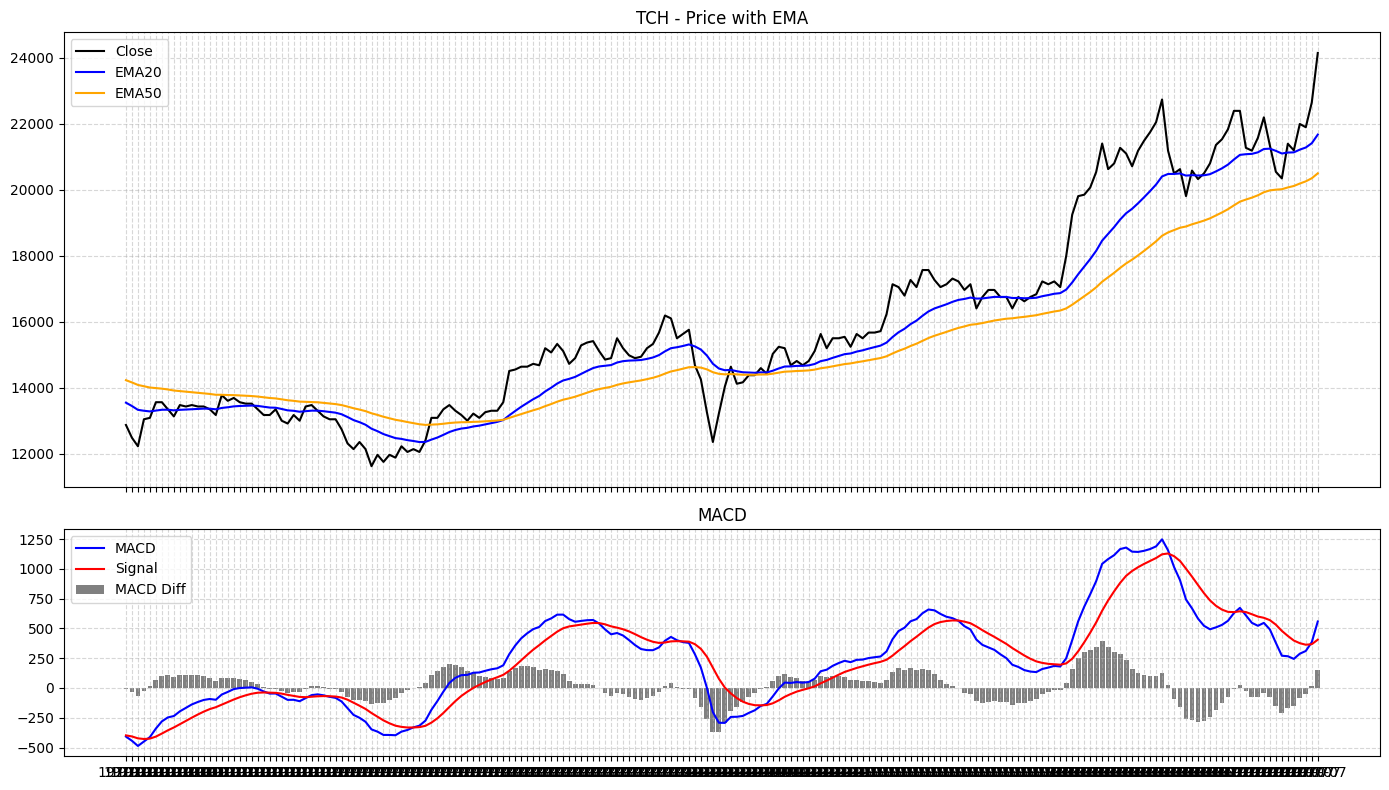

📈 Vẽ chart cho HSG


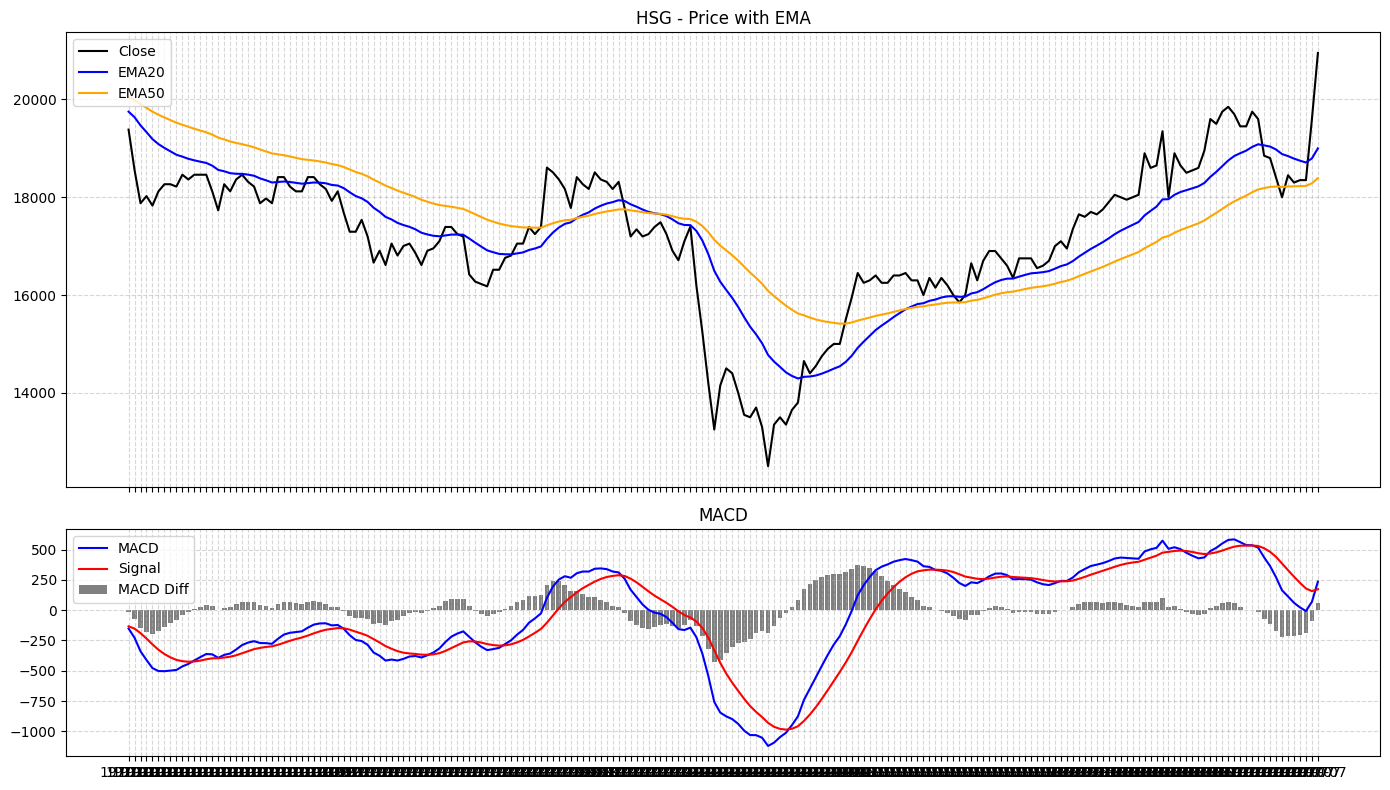

📈 Vẽ chart cho NKG


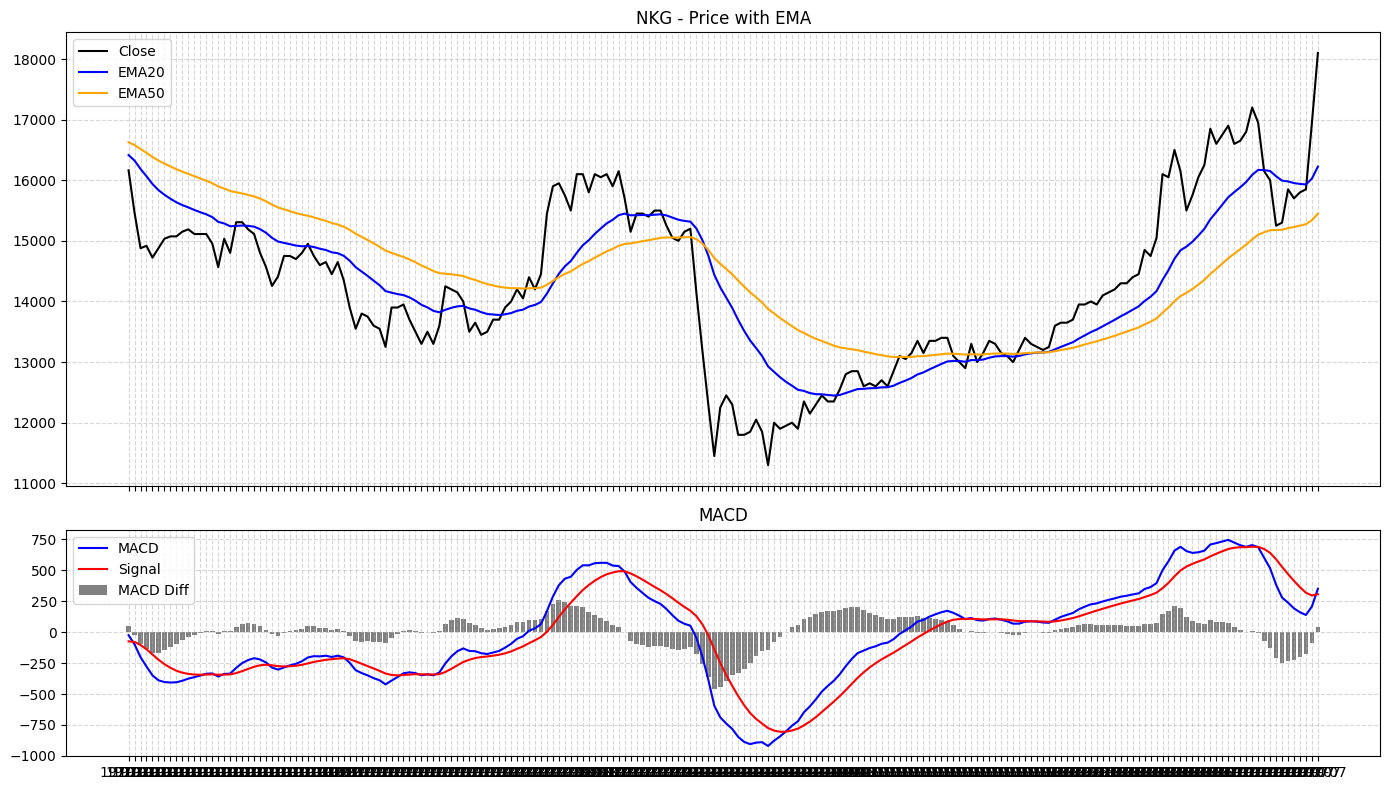

📈 Vẽ chart cho PNJ


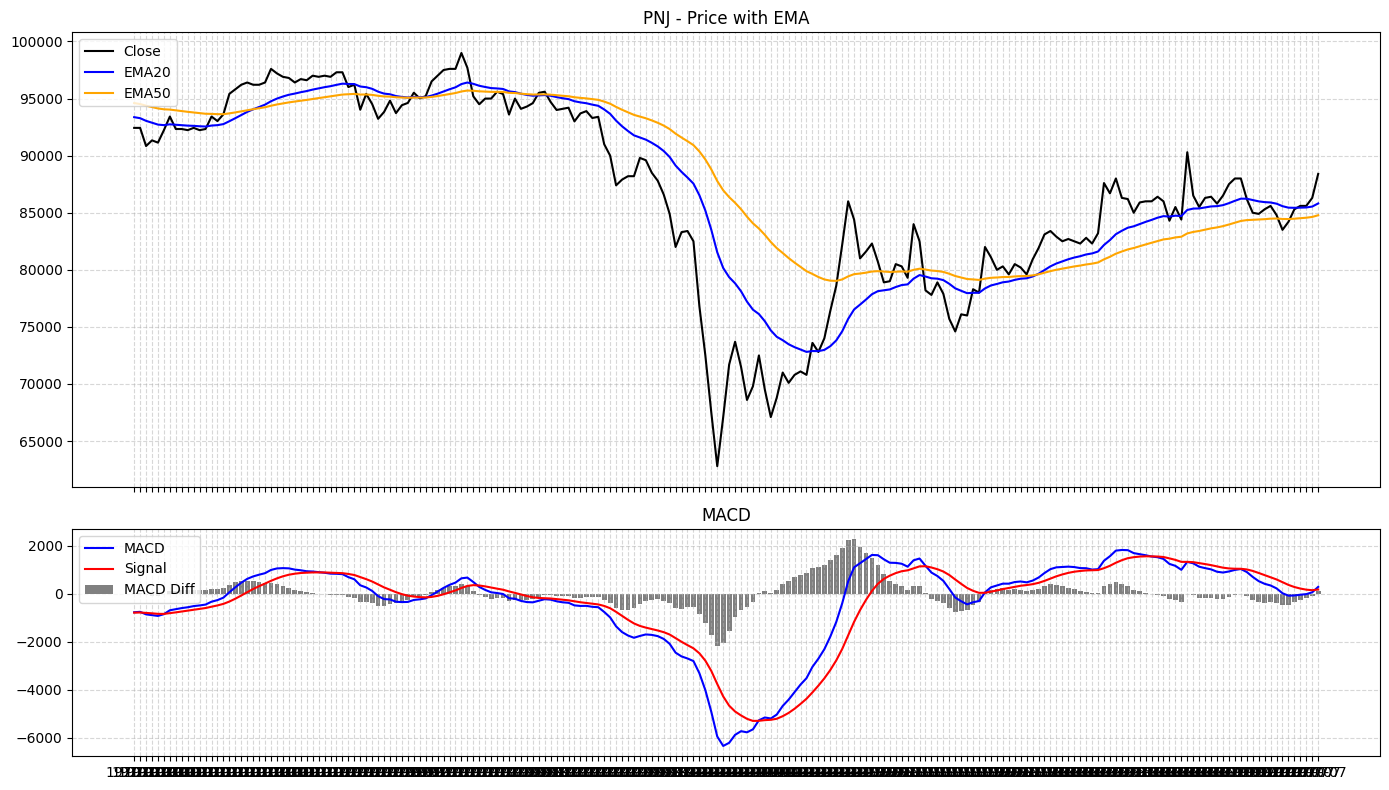

📈 Vẽ chart cho VCB


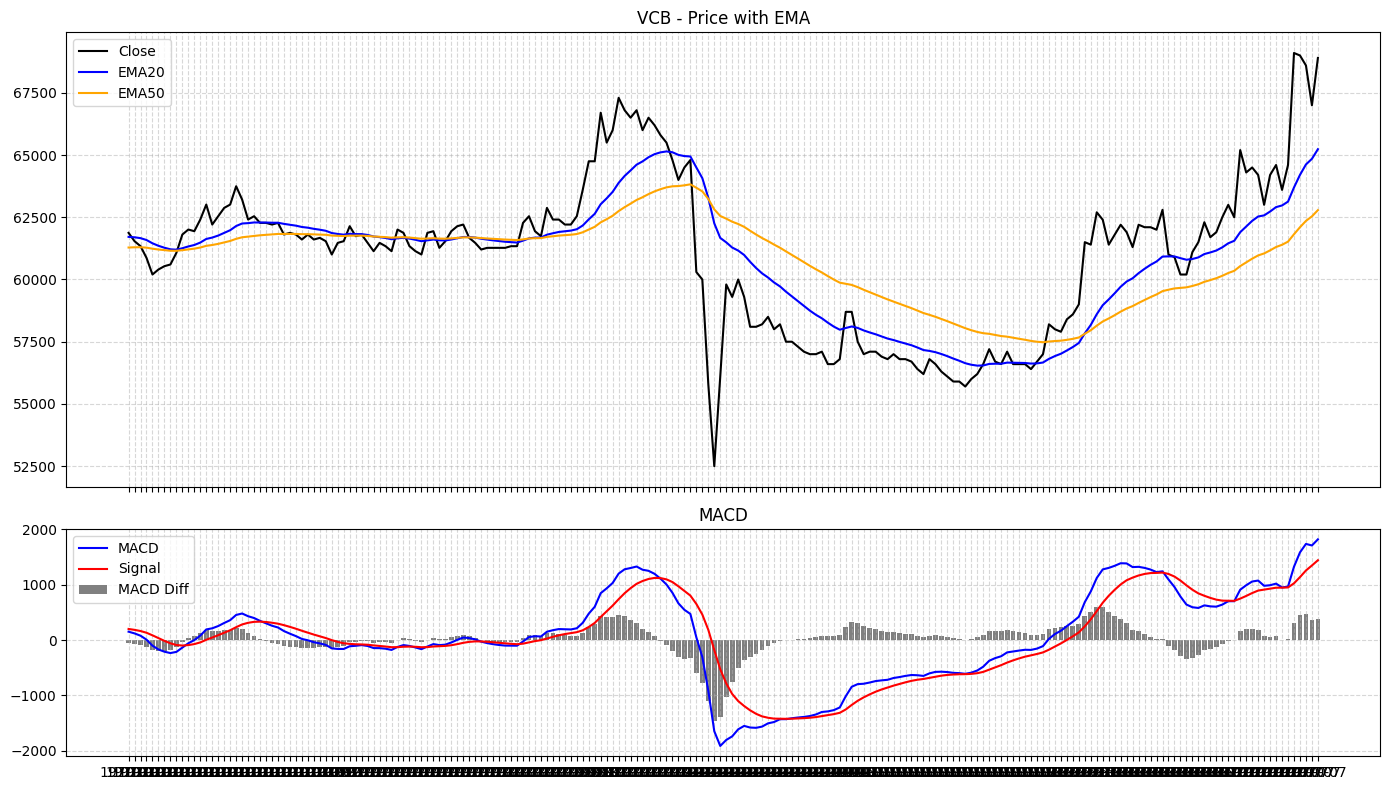

📈 Vẽ chart cho IMP


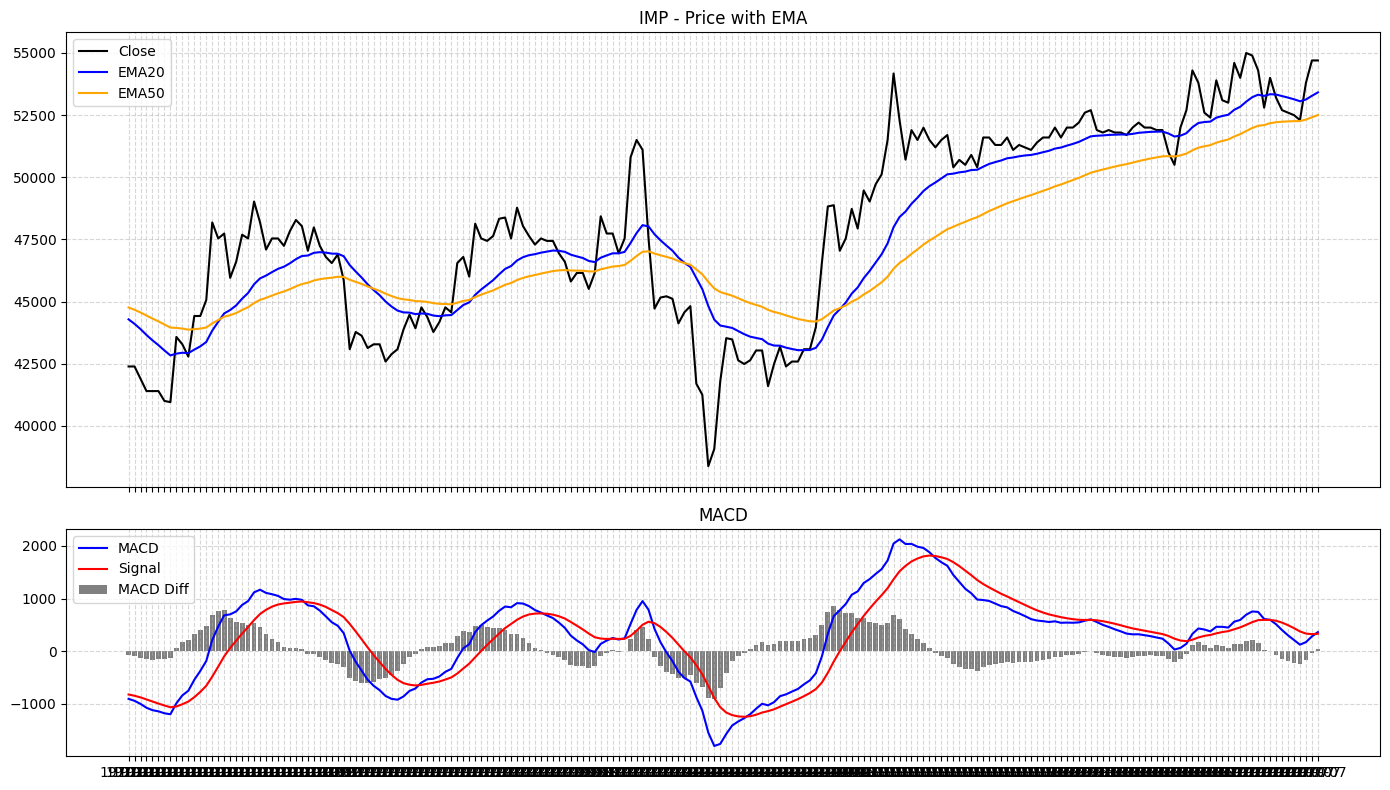

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from FiinQuantX import FiinSession
from datetime import datetime
import numpy as np 

# --- 1. Login ---
username = 'DSTC_38@fiinquant.vn'
password = 'Fiinquant0606'
client = FiinSession(username=username, password=password).login()

# --- 2. Load csv ---
data = pd.read_csv("data/data_2019_2025.csv")
df_ratios = pd.read_csv("data/fundamental_ratios_extracted_2019_2025.csv")
fi = client.FiinIndicator()

# --- 3. Ticker list ---
tickers_vn30 = list(client.TickerList(ticker="VN30"))
tickers_vnmid = list(client.TickerList(ticker="VNMid"))
tickers = tickers_vn30 + tickers_vnmid

scores = []

for ticker in tickers:
    df_t = data[data["ticker"] == ticker].copy()
    if len(df_t) < 200:
        continue

    last60 = df_t.tail(60).copy()
    last200 = df_t.tail(200).copy()

    # --- Criteria ---
    criteria = {
        "ticker": ticker,
        "Volatility": 0,
        "VolumeAccum": 0,
        "VolumeBreakout": 0,
        "MAtrend1": 0,
        "MAtrend2": 0,
        "PriceBreakout": 0,
        "EMA_score": 0,
        "MACD_score": 0,
        "ADX_score": 0,
        "FA_PE_ROE": 0
    }

    # --- Volatility ---
    price_min, price_max = last60["close"].min(), last60["close"].max()
    volatility = (price_max - price_min) / price_min
    if 0.05 <= volatility <= 0.25:
        criteria["Volatility"] = 2

    # --- Volume accumulation ---
    last60["Vol_MA20"] = last60["volume"].rolling(20).mean()
    vol_ma20_start = last60["Vol_MA20"].iloc[19]
    vol_ma20_end = last60["Vol_MA20"].iloc[-1]
    if not pd.isna(vol_ma20_start) and not pd.isna(vol_ma20_end):
        if vol_ma20_end < vol_ma20_start:
            criteria["VolumeAccum"] = 2

    # --- Volume breakout ---
    vol_avg20 = last60["volume"].tail(20).mean()
    if last60["volume"].iloc[-1] > 1.5 * vol_avg20:
        criteria["VolumeBreakout"] = 2

    # --- MA trend ---
    last200["MA20"] = last200["close"].rolling(20).mean()
    last200["MA50"] = last200["close"].rolling(50).mean()
    last200["MA200"] = last200["close"].rolling(200).mean()

    if last200["close"].iloc[-1] > last200["MA50"].iloc[-1]:
        criteria["MAtrend1"] = 1
    if last200["MA20"].iloc[-1] > last200["MA50"].iloc[-1]:
        criteria["MAtrend2"] = 2

    # --- Breakout giá ---
    if last60["close"].iloc[-1] > last60["close"].max() * 0.98:
        criteria["PriceBreakout"] = 2

    # --- EMA, MACD ---
    df_t["EMA20"] = fi.ema(df_t["close"], window=20)
    df_t["EMA50"] = fi.ema(df_t["close"], window=50)

    df_t["MACD"] = fi.macd(df_t["close"])
    df_t["MACD_signal"] = fi.macd_signal(df_t["close"])
    df_t["MACD_diff"] = fi.macd_diff(df_t["close"])

    latest = df_t.iloc[-1]

    # EMA
    if latest["close"] > latest["EMA20"] > latest["EMA50"]:
        criteria["EMA_score"] = 2
    elif latest["EMA20"] > latest["EMA50"]:
        criteria["EMA_score"] = 1

    # MACD
    if latest["MACD"] > latest["MACD_signal"]:
        criteria["MACD_score"] += 2
    if latest["MACD_diff"] > 0:
        criteria["MACD_score"] += 1

    # --- FA filter ---
    fa_row = df_ratios[df_ratios["ticker"] == ticker]
    if not fa_row.empty:
        pe = fa_row["PE"].iloc[0]
        roe = fa_row["ROE"].iloc[0]
        if pe <= 15 and roe >= 12:
            criteria["FA_PE_ROE"] = 3

    # --- Criteria ---
    criteria["score"] = sum([
        criteria["Volatility"],
        criteria["VolumeAccum"],
        criteria["VolumeBreakout"],
        criteria["MAtrend1"],
        criteria["MAtrend2"],
        criteria["PriceBreakout"],
        criteria["EMA_score"],
        criteria["MACD_score"],
        criteria["FA_PE_ROE"]
    ])

    scores.append(criteria)

# --- Ranks ---
df_score = pd.DataFrame(scores).sort_values("score", ascending=False)
print("Top cổ phiếu theo Wyckoff + EMA/MACD scoring:")
print(df_score.head(20))

df_score.to_csv("data/wyckoff_selected.csv", index=False, encoding="utf-8-sig")

# --- Plot chart ---
def plot_chart(df_t, ticker):
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                             gridspec_kw={'height_ratios': [2, 1]})

    # 1. Price + EMA
    axes[0].plot(df_t["timestamp"], df_t["close"], label="Close", color="black")
    axes[0].plot(df_t["timestamp"], df_t["EMA20"], label="EMA20", color="blue")
    axes[0].plot(df_t["timestamp"], df_t["EMA50"], label="EMA50", color="orange")
    axes[0].set_title(f"{ticker} - Price with EMA")
    axes[0].legend(loc="upper left")

    # 2. MACD
    axes[1].plot(df_t["timestamp"], df_t["MACD"], label="MACD", color="blue")
    axes[1].plot(df_t["timestamp"], df_t["MACD_signal"], label="Signal", color="red")
    axes[1].bar(df_t["timestamp"], df_t["MACD_diff"], label="MACD Diff", color="gray")
    axes[1].set_title("MACD")
    axes[1].legend(loc="upper left")

    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
    
    
    
# --- Boost score cho các mã có trong SVM_selected.csv ---
df_svm = pd.read_csv("data/SVM_selected.csv")
svm_tickers = set(df_svm["ticker"].unique())

# Thêm cột SVM_boosted: 3 điểm nếu có trong SVM, ngược lại 0
df_score["SVM_boosted"] = df_score["ticker"].apply(lambda x: 1 if x in svm_tickers else 0)

# Cập nhật score
df_score["score"] = df_score["score"] + df_score["SVM_boosted"]

# Lưu lại final.csv (sau khi boost)
df_score.to_csv("data/final.csv", index=False, encoding="utf-8-sig")

# --- Scan cổ phiếu có score >= 12 ---
top_candidates = df_score[df_score["score"] >= 12]
print("Ứng viên score >= 12:")
print(top_candidates[["ticker", "score"]])

for ticker in top_candidates["ticker"].tolist():
    df_t = data[data["ticker"] == ticker].copy()
    df_t["EMA20"] = fi.ema(df_t["close"], window=20)
    df_t["EMA50"] = fi.ema(df_t["close"], window=50)
    df_t["MACD"] = fi.macd(df_t["close"])
    df_t["MACD_signal"] = fi.macd_signal(df_t["close"])
    df_t["MACD_diff"] = fi.macd_diff(df_t["close"])
    df_t = df_t.tail(200)  
    print(f"📈 Vẽ chart cho {ticker}")
    plot_chart(df_t, ticker)

# Comparision with VNINDEX: 

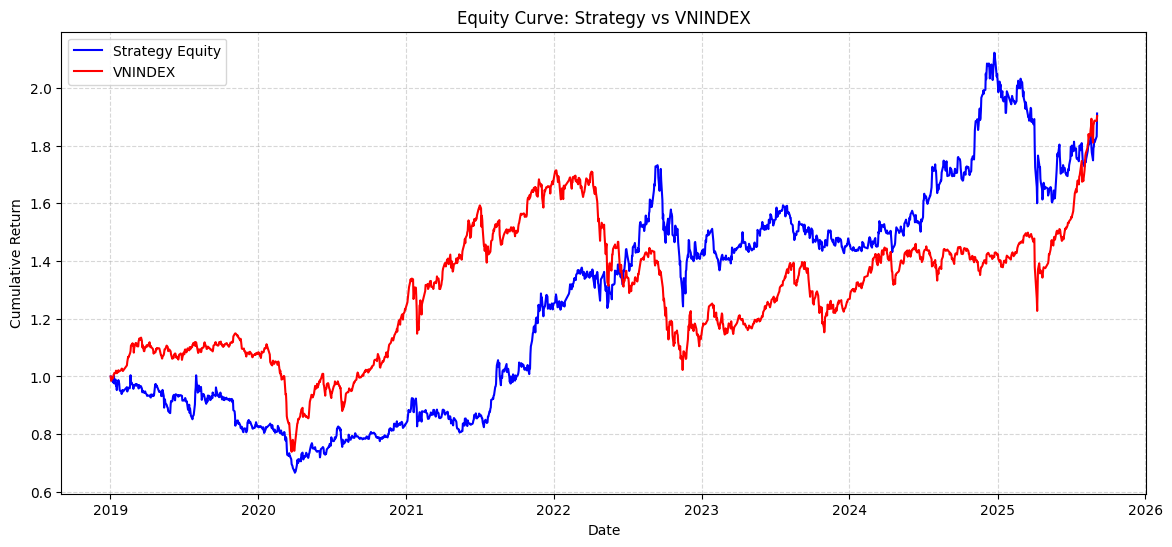

✅ Chiến lược outperform VNINDEX


In [2]:
vnindex = pd.read_csv("data/vnindex_equity.csv")
vnindex["timestamp"] = pd.to_datetime(vnindex["timestamp"])
data["timestamp"] = pd.to_datetime(data["timestamp"])
top_candidates = df_score[df_score["score"] >= 14]  
tickers_list = top_candidates["ticker"].tolist()
strategy_data = data[data["ticker"].isin(tickers_list)].copy()
strategy_prices = strategy_data.groupby("timestamp")["close"].mean()

strategy_returns = strategy_prices.pct_change().fillna(0)
strategy_equity = (1 + strategy_returns).cumprod()


vnindex_equity = vnindex.set_index("timestamp")["equity_curve"]

plt.figure(figsize=(14, 6))
plt.plot(strategy_equity.index, strategy_equity, label="Strategy Equity", color="blue")
plt.plot(vnindex_equity.index, vnindex_equity, label="VNINDEX", color="red")
plt.legend()
plt.title("Equity Curve: Strategy vs VNINDEX")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

if strategy_equity.iloc[-1] > vnindex_equity.iloc[-1]:
    print("✅ Chiến lược outperform VNINDEX")
else:
    print("❌ Chiến lược underperform VNINDEX")


# Personal asset chart: 

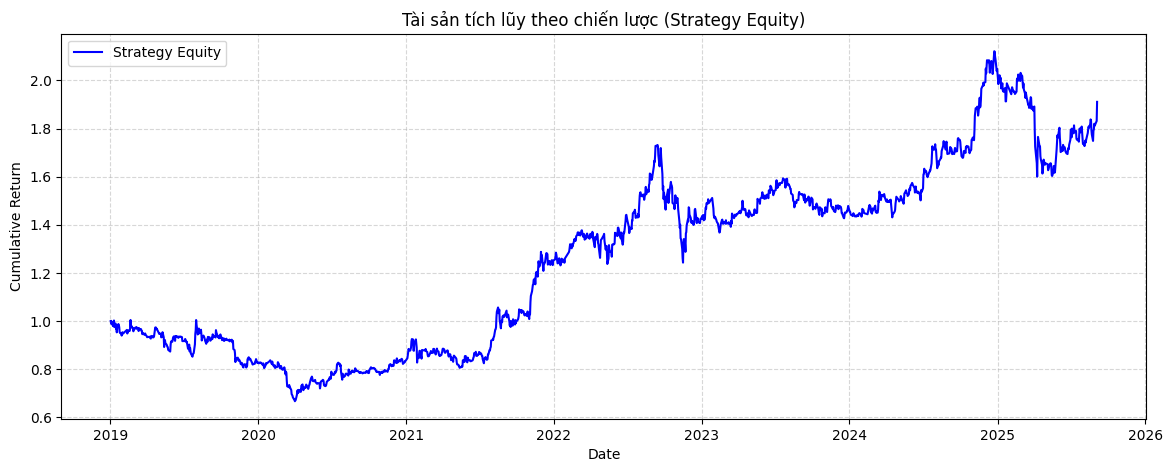

In [3]:
plt.figure(figsize=(14, 5))
plt.plot(strategy_equity.index, strategy_equity, label="Strategy Equity", color="blue")
plt.title("Tài sản tích lũy theo chiến lược (Strategy Equity)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Indicators:

In [4]:
# --- Total number of trades ---
num_trades = strategy_returns[strategy_returns != 0].count()

In [5]:
# --- Max Drawdown ---
rolling_max = strategy_equity.cummax()
drawdown = (strategy_equity - rolling_max) / rolling_max
max_drawdown = drawdown.min()

In [6]:
# --- Backtest Indicators ---
total_return = strategy_equity.iloc[-1] - 1
annual_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
annual_vol = strategy_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else np.nan

In [7]:
print("===== Backtest Summary (Strategy) =====")
print(f"📊 Total number of trades: {num_trades}")
print(f"📉 Max Drawdown: {max_drawdown:.2%}")
print(f"💰 Total Profit: {total_return:.2%}")
print(f"📈 Annualized Return: {annual_return:.2%}")
print(f"⚡ Annualized Volatility: {annual_vol:.2%}")
print(f"📐 Sharpe Ratio: {sharpe_ratio:.2f}")

===== Backtest Summary (Strategy) =====
📊 Total number of trades: 1642
📉 Max Drawdown: -33.63%
💰 Total Profit: 91.11%
📈 Annualized Return: 10.30%
⚡ Annualized Volatility: 21.25%
📐 Sharpe Ratio: 0.48
